In [2]:
import os
import sys

# Obtener el directorio actual del notebook
notebook_dir = os.getcwd()
print("Directorio actual:", notebook_dir)

# Ir al directorio raíz del proyecto (si el notebook está en la carpeta notebooks)
project_dir = notebook_dir
if os.path.basename(notebook_dir) == 'notebooks':
    project_dir = os.path.dirname(notebook_dir)
    os.chdir(project_dir)
    print("Cambiado a directorio:", os.getcwd())
else:
    print("Ya parece estar en el directorio raíz")

# Añadir el directorio raíz al path
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
    print("Añadido al path:", project_dir)
else:
    print("El directorio ya está en el path")

# Verificar que utils esté accesible
print("Contenido del directorio raíz:", os.listdir())
print("Contenido de utils:", os.listdir('utils') if os.path.exists('utils') else "La carpeta utils no existe")

Directorio actual: c:\Users\aleja\Desktop\deepProject\anomalyDetection_project\notebooks
Cambiado a directorio: c:\Users\aleja\Desktop\deepProject\anomalyDetection_project
Añadido al path: c:\Users\aleja\Desktop\deepProject\anomalyDetection_project
Contenido del directorio raíz: ['.git', 'data', 'models', 'notebooks', 'results', 'utils']
Contenido de utils: ['data_loader.py', 'evaluation.py', 'model_utils.py', '__pycache__']


2025-05-14 18:50:13,748 - INFO - Usando dispositivo: cpu
2025-05-14 18:50:13,749 - INFO - Charging data from data/machine_temperature_system_failure.csv
2025-05-14 18:50:13,769 - INFO - Charged data: 22695 registers
2025-05-14 18:50:13,770 - INFO - Charging labels from data/known_labels_v1.0.json and data/combined_windows.json
2025-05-14 18:50:13,783 - INFO - Data division: Train 1578, Val 338, Test 339


Modelos cargados correctamente desde models/autoencoder/


2025-05-14 18:50:15,378 - INFO - Ensemble created with 3 models and weights [0.33333333 0.33333333 0.33333333]
2025-05-14 18:50:15,383 - INFO - Weights optimized based on AUC: [0.35199046 0.35636811 0.29164142]
2025-05-14 18:50:15,660 - INFO - Model LSTM: Mean Error 0.04456, Std 0.07924
2025-05-14 18:50:16,007 - INFO - Model GRU: Mean Error 0.04766, Std 0.10210
2025-05-14 18:50:16,095 - INFO - Model Transformer: Mean Error 0.00015, Std 0.00027
2025-05-14 18:50:16,381 - INFO - Model LSTM: Mean Error 0.02670, Std 0.02439
2025-05-14 18:50:16,701 - INFO - Model GRU: Mean Error 0.03545, Std 0.03759
2025-05-14 18:50:16,809 - INFO - Model Transformer: Mean Error 0.00007, Std 0.00006



=== Comparison of Threshold Approaches (Ensemble Model) ===
Approach        Precision  Recall     F1-Score   FP     FN    
------------------------------------------------------------
Static          1.0000     0.6094     0.7573     0      25    
Rolling         0.5732     0.7344     0.6438     35     17    
Seasonal        0.2295     0.4375     0.3011     94     36    
Adaptive        1.0000     0.7969     0.8870     0      13    


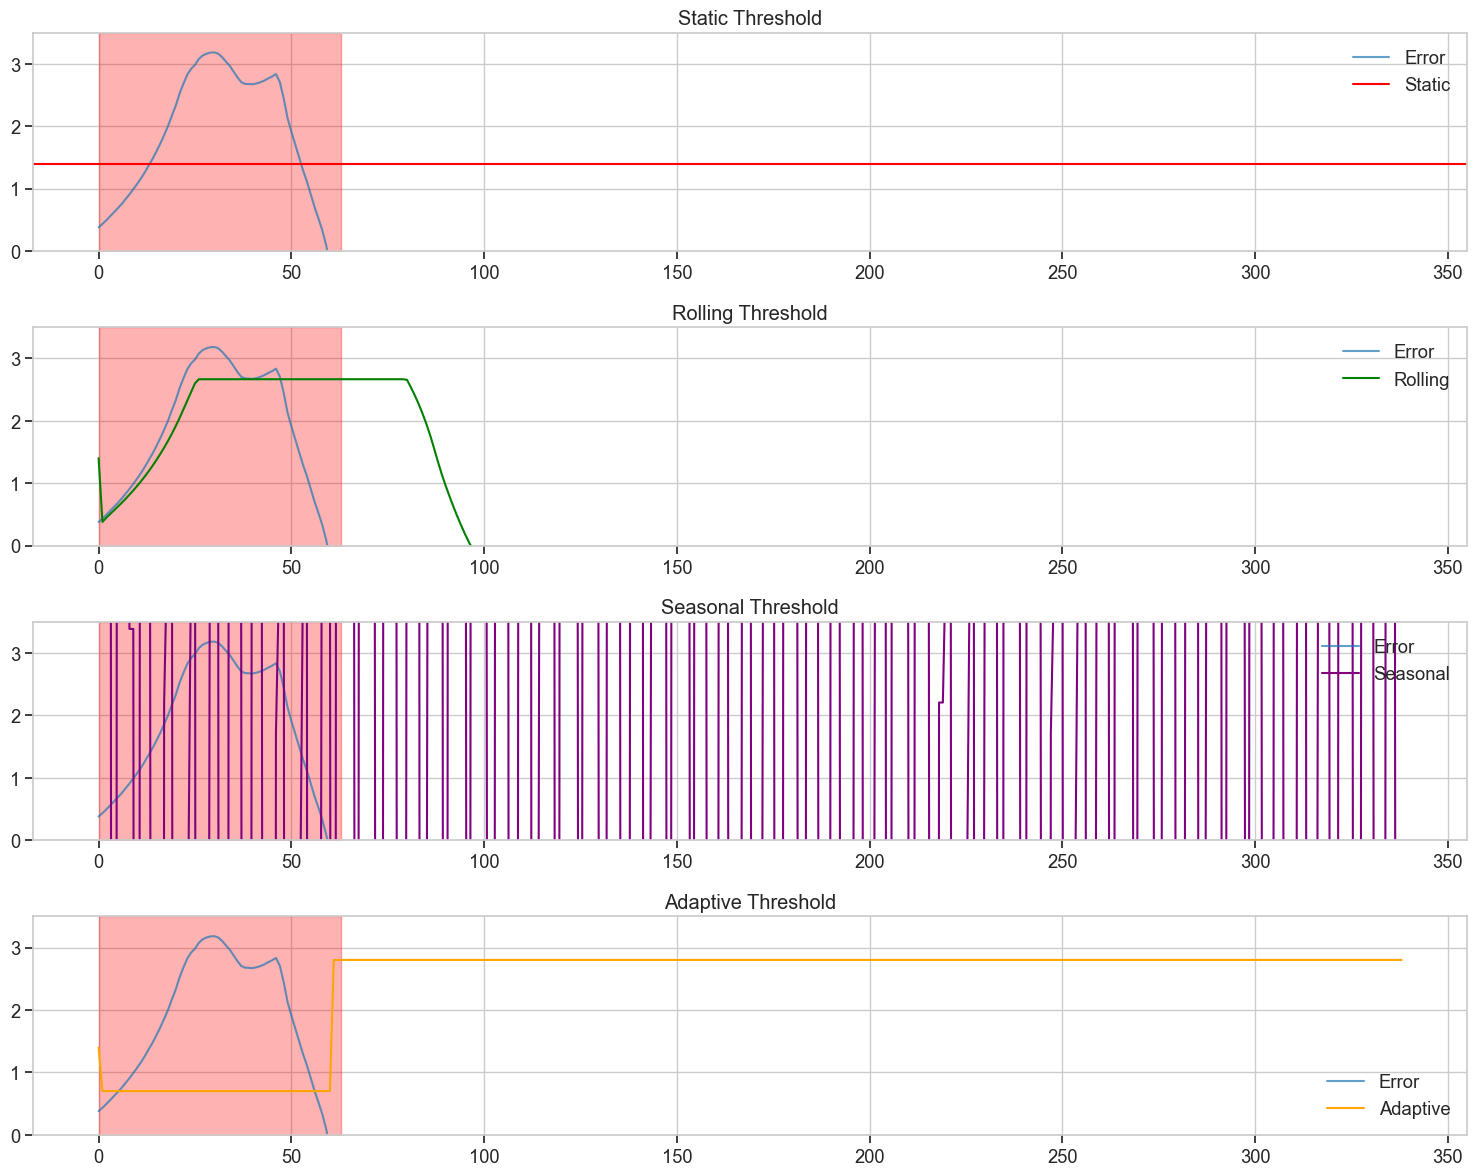


=== Hybrid Threshold Results (Ensemble Model) ===
Precision: 0.2683
Recall: 0.5156
F1-Score: 0.3529
FP: 90, FN: 31


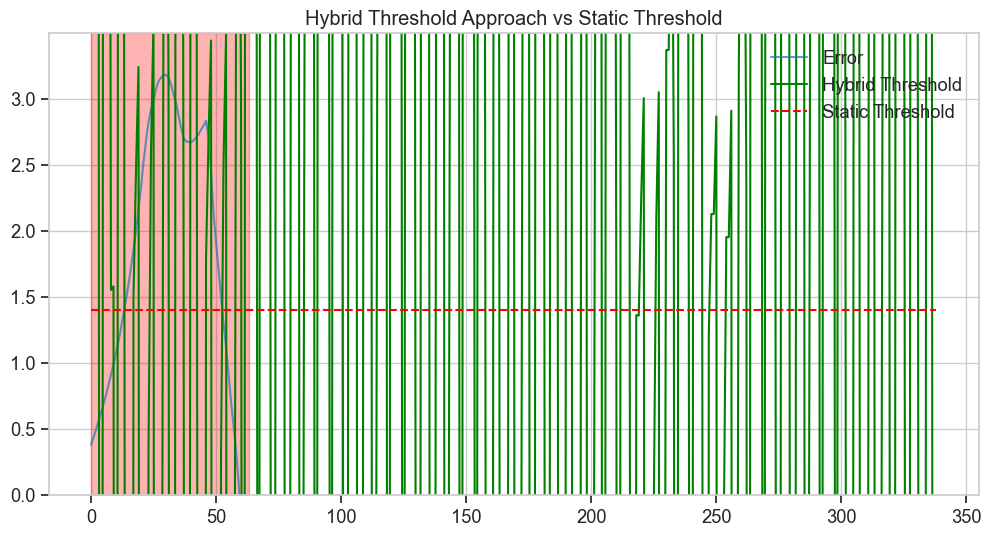

Best weights found: (np.float64(0.0), np.float64(0.0), np.float64(1.0)) with F1-Score: 0.8870

=== Optimized Hybrid Threshold Results (Ensemble Model) ===
Precision: 1.0000
Recall: 0.7969
F1-Score: 0.8870
FP: 0, FN: 13

=== Final Comparison of All Threshold Approaches (Ensemble Model) ===
Approach             Precision  Recall     F1-Score   FP     FN    
----------------------------------------------------------------------
Static               1.0000     0.6094     0.7573     0      25    
Rolling              0.5732     0.7344     0.6438     35     17    
Seasonal             0.2295     0.4375     0.3011     94     36    
Adaptive             1.0000     0.7969     0.8870     0      13    
Hybrid (Equal)       0.2683     0.5156     0.3529     90     31    
Hybrid (Optimized)   1.0000     0.7969     0.8870     0      13    
Hybrid threshold model saved to models/dynamic_thresholds/hybrid_threshold_model.pkl


In [6]:
# **Dynamic Thresholds for Anomaly Detection**
# 
# This notebook implements dynamic thresholding approaches to improve anomaly detection

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import logging

# Import custom modules
import sys
sys.path.append('./')
from utils.data_loader import load_data, load_anomaly_labels, normalize_data, create_sequences
from utils.data_loader import create_labels_array, split_data, prepare_data_loaders
from utils.model_utils import load_trained_models, get_reconstruction_errors, EnsembleModel
from utils.evaluation import evaluate_threshold, AnomalyInterpreter, visualize_results
from utils.evaluation import plot_roc_curves, plot_precision_recall_curves, create_results_summary, print_results_table

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Usando dispositivo: {device}")

# Load data
filepath = 'data/machine_temperature_system_failure.csv'
labels_path = 'data/known_labels_v1.0.json'
windows_path = 'data/combined_windows.json'

df = load_data(filepath)
labels_dict, windows_dict = load_anomaly_labels(labels_path, windows_path)

filename = 'realKnownCause/machine_temperature_system_failure.csv'
anomaly_timestamps = labels_dict[filename]
anomaly_windows = windows_dict[filename]

data_scaled, scaler = normalize_data(df[['value']])

sequence_length = 150
step = 10

X = create_sequences(data_scaled, sequence_length, step)
y = create_labels_array(df, anomaly_timestamps, anomaly_windows, sequence_length, step)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

batch_size = 64
train_loader, val_loader, test_loader = prepare_data_loaders(X_train, X_val, X_test, batch_size)

# Load pretrained models
# Load pretrained models
def load_models_with_correct_dimensions():
    """Carga modelos con las dimensiones correctas."""
    import json
    import os
    import torch
    from utils.model_utils import LSTMAutoencoder, GRUAutoencoder, TransformerEncoder
    
    base_path = "models/autoencoder/"
    
    # Cargar metadatos
    try:
        with open(os.path.join(base_path, "model_metadata.json"), "r") as f:
            metadata = json.load(f)
    except FileNotFoundError:
        print("Archivo de metadatos no encontrado, usando valores por defecto.")
        metadata = {"embedding_dim": 64}
    
    seq_len = sequence_length
    n_features = 1
    embedding_dim = metadata.get("embedding_dim", 64)
    
    # Importante: usar d_model=48 para el Transformer
    lstm_model = LSTMAutoencoder(seq_len=seq_len, n_features=n_features, embedding_dim=embedding_dim)
    gru_model = GRUAutoencoder(seq_len=seq_len, n_features=n_features, embedding_dim=embedding_dim)
    transformer_model = TransformerEncoder(seq_len=seq_len, n_features=n_features, d_model=48, nhead=4)
    
    # Cargar pesos
    try:
        lstm_model.load_state_dict(torch.load(os.path.join(base_path, "lstm_model.pt")))
        gru_model.load_state_dict(torch.load(os.path.join(base_path, "gru_model.pt")))
        transformer_model.load_state_dict(torch.load(os.path.join(base_path, "transformer_model.pt")))
        print(f"Modelos cargados correctamente desde {base_path}")
    except Exception as e:
        print(f"Error al cargar modelos: {e}")
        print("Usando modelos sin entrenar")
    
    return {
        "lstm": lstm_model,
        "gru": gru_model,
        "transformer": transformer_model
    }, metadata

# Reemplazar la llamada a load_trained_models con esta nueva función
models, metadata = load_models_with_correct_dimensions()
lstm_model = models["lstm"]
gru_model = models["gru"]
transformer_model = models["transformer"]

# Get reconstruction errors
lstm_errors, lstm_orig, lstm_recon = get_reconstruction_errors(lstm_model, test_loader, device)
gru_errors, gru_orig, gru_recon = get_reconstruction_errors(gru_model, test_loader, device)
transformer_errors, transformer_orig, transformer_recon = get_reconstruction_errors(transformer_model, test_loader, device)

val_lstm_errors, _, _ = get_reconstruction_errors(lstm_model, val_loader, device)
val_gru_errors, _, _ = get_reconstruction_errors(gru_model, val_loader, device)
val_transformer_errors, _, _ = get_reconstruction_errors(transformer_model, val_loader, device)

# Function to create dynamic threshold
class DynamicThresholdGenerator:
    def __init__(self, window_size=30):
        self.window_size = window_size
    
    def rolling_threshold(self, errors, val_errors, factor=1.5, min_percentile=50, max_percentile=99):
        """
        Generates dynamic thresholds using rolling statistics.
        """
        base_threshold = np.mean(val_errors) + factor * np.std(val_errors)
        thresholds = np.zeros_like(errors)
        
        for i in range(len(errors)):
            start_idx = max(0, i - self.window_size)
            end_idx = i
            window = errors[start_idx:end_idx]
            
            if len(window) > 0:
                local_mean = np.mean(window)
                local_std = np.std(window)
                window_threshold = local_mean + factor * local_std
                
                # Ensure threshold is not too low or too high
                min_thresh = np.percentile(val_errors, min_percentile)
                max_thresh = np.percentile(val_errors, max_percentile)
                
                window_threshold = max(min_thresh, min(max_thresh, window_threshold))
                thresholds[i] = window_threshold
            else:
                thresholds[i] = base_threshold
        
        return thresholds
    
    def seasonal_threshold(self, errors, timestamps, val_errors, factor=1.5, 
                          seasonal_periods={"daily": 24, "weekly": 168}):
        """
        Generate thresholds that account for seasonal patterns.
        """
        if not isinstance(timestamps[0], pd.Timestamp):
            timestamps = pd.to_datetime(timestamps)
        
        thresholds = np.zeros_like(errors)
        base_threshold = np.mean(val_errors) + factor * np.std(val_errors)
        
        # Extract time features
        hour_of_day = np.array([ts.hour for ts in timestamps])
        day_of_week = np.array([ts.dayofweek for ts in timestamps])
        
        # Calculate hourly patterns
        hourly_means = {}
        hourly_stds = {}
        
        for hour in range(24):
            mask = hour_of_day == hour
            if np.sum(mask) > 0:
                hourly_means[hour] = np.mean(errors[mask])
                hourly_stds[hour] = np.std(errors[mask])
        
        # Calculate daily patterns (by day of week)
        daily_means = {}
        daily_stds = {}
        
        for day in range(7):
            mask = day_of_week == day
            if np.sum(mask) > 0:
                daily_means[day] = np.mean(errors[mask])
                daily_stds[day] = np.std(errors[mask])
        
        # Generate thresholds with seasonal adjustments
        for i, (ts, error) in enumerate(zip(timestamps, errors)):
            hour = ts.hour
            day = ts.dayofweek
            
            # Get seasonal factors
            hour_factor = 1.0
            if hour in hourly_means:
                hour_deviation = (hourly_means[hour] - np.mean(list(hourly_means.values()))) / np.mean(list(hourly_means.values()))
                hour_factor = 1.0 + hour_deviation
            
            day_factor = 1.0
            if day in daily_means:
                day_deviation = (daily_means[day] - np.mean(list(daily_means.values()))) / np.mean(list(daily_means.values()))
                day_factor = 1.0 + day_deviation
            
            # Combine factors and apply to base threshold
            combined_factor = (hour_factor + day_factor) / 2
            thresholds[i] = base_threshold * combined_factor
        
        return thresholds
    
    def adaptive_threshold(self, errors, val_errors, factor=1.5, adaptivity=0.2):
        """
        Generate thresholds that adapt to changes in error magnitude.
        """
        base_threshold = np.mean(val_errors) + factor * np.std(val_errors)
        thresholds = np.zeros_like(errors)
        
        # Initial threshold
        thresholds[0] = base_threshold
        
        # Adaptive thresholding
        for i in range(1, len(errors)):
            current_err_magnitude = errors[i-1] / np.mean(val_errors)
            adaptation = 1.0 + adaptivity * (current_err_magnitude - 1.0)
            adaptation = max(0.5, min(adaptation, 2.0))  # Limit adaptation factor
            
            thresholds[i] = base_threshold * adaptation
        
        return thresholds

# Create dynamic thresholds
threshold_generator = DynamicThresholdGenerator(window_size=40)

# Evaluate with each threshold type
# 1. Rolling threshold
rolling_lstm_thresholds = threshold_generator.rolling_threshold(lstm_errors, val_lstm_errors, factor=1.5)
rolling_gru_thresholds = threshold_generator.rolling_threshold(gru_errors, val_gru_errors, factor=1.5)
rolling_transformer_thresholds = threshold_generator.rolling_threshold(transformer_errors, val_transformer_errors, factor=1.5)

# 2. Seasonal threshold (assuming we have timestamps)
timestamps = df.index[sequence_length:][::step][-len(lstm_errors):]
seasonal_lstm_thresholds = threshold_generator.seasonal_threshold(lstm_errors, timestamps, val_lstm_errors)
seasonal_gru_thresholds = threshold_generator.seasonal_threshold(gru_errors, timestamps, val_gru_errors)
seasonal_transformer_thresholds = threshold_generator.seasonal_threshold(transformer_errors, timestamps, val_transformer_errors)

# 3. Adaptive threshold
adaptive_lstm_thresholds = threshold_generator.adaptive_threshold(lstm_errors, val_lstm_errors)
adaptive_gru_thresholds = threshold_generator.adaptive_threshold(gru_errors, val_gru_errors)
adaptive_transformer_thresholds = threshold_generator.adaptive_threshold(transformer_errors, val_transformer_errors)

# Create ensemble model
ensemble = EnsembleModel(
    models=[lstm_model, gru_model, transformer_model],
    names=["LSTM", "GRU", "Transformer"]
)

ensemble.optimize_weights(
    [val_lstm_errors, val_gru_errors, val_transformer_errors],
    y_val
)

ensemble_errors, individual_errors = ensemble.get_weighted_errors(
    [test_loader, test_loader, test_loader],
    device
)

val_ensemble_errors, _ = ensemble.get_weighted_errors(
    [val_loader, val_loader, val_loader],
    device
)

# Create dynamic thresholds for ensemble
rolling_ensemble_thresholds = threshold_generator.rolling_threshold(ensemble_errors, val_ensemble_errors)
seasonal_ensemble_thresholds = threshold_generator.seasonal_threshold(ensemble_errors, timestamps, val_ensemble_errors)
adaptive_ensemble_thresholds = threshold_generator.adaptive_threshold(ensemble_errors, val_ensemble_errors)

# Evaluate dynamic thresholds

def evaluate_with_dynamic_threshold(errors, y_true, thresholds):
    """Evaluate model with dynamic thresholds."""
    y_pred = (errors > thresholds).astype(int)
    
    from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, precision_recall_curve, auc
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0

    try:
        auc_roc = roc_auc_score(y_true, errors)
    except:
        auc_roc = np.nan

    precision_pr, recall_pr, _ = precision_recall_curve(y_true, errors)
    auc_pr = auc(recall_pr, precision_pr)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr,
        'tpr': tpr,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'threshold_mean': np.mean(thresholds),
        'threshold_std': np.std(thresholds)
    }

# Evaluate all models with all threshold types
# Static threshold (baseline)
static_lstm_results = evaluate_threshold(lstm_errors, y_test, val_lstm_errors, factor=1.5)
static_gru_results = evaluate_threshold(gru_errors, y_test, val_gru_errors, factor=1.5)
static_transformer_results = evaluate_threshold(transformer_errors, y_test, val_transformer_errors, factor=1.5)
static_ensemble_results = evaluate_threshold(ensemble_errors, y_test, val_ensemble_errors, factor=1.5)

# Rolling threshold
rolling_lstm_results = evaluate_with_dynamic_threshold(lstm_errors, y_test, rolling_lstm_thresholds)
rolling_gru_results = evaluate_with_dynamic_threshold(gru_errors, y_test, rolling_gru_thresholds)
rolling_transformer_results = evaluate_with_dynamic_threshold(transformer_errors, y_test, rolling_transformer_thresholds)
rolling_ensemble_results = evaluate_with_dynamic_threshold(ensemble_errors, y_test, rolling_ensemble_thresholds)

# Seasonal threshold
seasonal_lstm_results = evaluate_with_dynamic_threshold(lstm_errors, y_test, seasonal_lstm_thresholds)
seasonal_gru_results = evaluate_with_dynamic_threshold(gru_errors, y_test, seasonal_gru_thresholds)
seasonal_transformer_results = evaluate_with_dynamic_threshold(transformer_errors, y_test, seasonal_transformer_thresholds)
seasonal_ensemble_results = evaluate_with_dynamic_threshold(ensemble_errors, y_test, seasonal_ensemble_thresholds)

# Adaptive threshold
adaptive_lstm_results = evaluate_with_dynamic_threshold(lstm_errors, y_test, adaptive_lstm_thresholds)
adaptive_gru_results = evaluate_with_dynamic_threshold(gru_errors, y_test, adaptive_gru_thresholds)
adaptive_transformer_results = evaluate_with_dynamic_threshold(transformer_errors, y_test, adaptive_transformer_thresholds)
adaptive_ensemble_results = evaluate_with_dynamic_threshold(ensemble_errors, y_test, adaptive_ensemble_thresholds)

# Compare threshold approaches
print("\n=== Comparison of Threshold Approaches (Ensemble Model) ===")
print(f"{'Approach':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'FP':<6} {'FN':<6}")
print("-" * 60)

print(f"{'Static':<15} {static_ensemble_results['precision']:<10.4f} {static_ensemble_results['recall']:<10.4f} "
      f"{static_ensemble_results['f1']:<10.4f} {static_ensemble_results['fp']:<6d} {static_ensemble_results['fn']:<6d}")

print(f"{'Rolling':<15} {rolling_ensemble_results['precision']:<10.4f} {rolling_ensemble_results['recall']:<10.4f} "
      f"{rolling_ensemble_results['f1']:<10.4f} {rolling_ensemble_results['fp']:<6d} {rolling_ensemble_results['fn']:<6d}")

print(f"{'Seasonal':<15} {seasonal_ensemble_results['precision']:<10.4f} {seasonal_ensemble_results['recall']:<10.4f} "
      f"{seasonal_ensemble_results['f1']:<10.4f} {seasonal_ensemble_results['fp']:<6d} {seasonal_ensemble_results['fn']:<6d}")

print(f"{'Adaptive':<15} {adaptive_ensemble_results['precision']:<10.4f} {adaptive_ensemble_results['recall']:<10.4f} "
      f"{adaptive_ensemble_results['f1']:<10.4f} {adaptive_ensemble_results['fp']:<6d} {adaptive_ensemble_results['fn']:<6d}")

# Visualize threshold comparison
plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(ensemble_errors, label='Error', alpha=0.7)
plt.axhline(y=static_ensemble_results['threshold'], color='r', linestyle='-', label='Static')
plt.fill_between(range(len(y_test)), 0, 1, where=y_test > 0, alpha=0.3, color='red', transform=plt.gca().get_xaxis_transform())
plt.ylim(0, max(ensemble_errors) * 1.1)
plt.legend()
plt.title('Static Threshold')

plt.subplot(4, 1, 2)
plt.plot(ensemble_errors, label='Error', alpha=0.7)
plt.plot(rolling_ensemble_thresholds, label='Rolling', color='g', linestyle='-')
plt.fill_between(range(len(y_test)), 0, 1, where=y_test > 0, alpha=0.3, color='red', transform=plt.gca().get_xaxis_transform())
plt.ylim(0, max(ensemble_errors) * 1.1)
plt.legend()
plt.title('Rolling Threshold')

plt.subplot(4, 1, 3)
plt.plot(ensemble_errors, label='Error', alpha=0.7)
plt.plot(seasonal_ensemble_thresholds, label='Seasonal', color='purple', linestyle='-')
plt.fill_between(range(len(y_test)), 0, 1, where=y_test > 0, alpha=0.3, color='red', transform=plt.gca().get_xaxis_transform())
plt.ylim(0, max(ensemble_errors) * 1.1)
plt.legend()
plt.title('Seasonal Threshold')

plt.subplot(4, 1, 4)
plt.plot(ensemble_errors, label='Error', alpha=0.7)
plt.plot(adaptive_ensemble_thresholds, label='Adaptive', color='orange', linestyle='-')
plt.fill_between(range(len(y_test)), 0, 1, where=y_test > 0, alpha=0.3, color='red', transform=plt.gca().get_xaxis_transform())
plt.ylim(0, max(ensemble_errors) * 1.1)
plt.legend()
plt.title('Adaptive Threshold')

plt.tight_layout()
plt.savefig('threshold_comparison.png', dpi=300)
plt.show()

# Implement hybrid threshold approach
class HybridThresholdGenerator:
    def __init__(self, window_size=30):
        self.window_size = window_size
        self.threshold_generator = DynamicThresholdGenerator(window_size)
    
    def hybrid_threshold(self, errors, timestamps, val_errors, weights=(0.4, 0.3, 0.3), factor=1.5):
        """
        Combine multiple threshold approaches with weights.
        weights: tuple of (rolling_weight, seasonal_weight, adaptive_weight)
        """
        rolling_thresholds = self.threshold_generator.rolling_threshold(errors, val_errors, factor)
        seasonal_thresholds = self.threshold_generator.seasonal_threshold(errors, timestamps, val_errors, factor)
        adaptive_thresholds = self.threshold_generator.adaptive_threshold(errors, val_errors, factor)
        
        hybrid_thresholds = (
            weights[0] * rolling_thresholds + 
            weights[1] * seasonal_thresholds + 
            weights[2] * adaptive_thresholds
        )
        
        return hybrid_thresholds

# Create hybrid thresholds
hybrid_generator = HybridThresholdGenerator(window_size=40)
hybrid_ensemble_thresholds = hybrid_generator.hybrid_threshold(
    ensemble_errors, timestamps, val_ensemble_errors
)

# Evaluate hybrid approach
hybrid_ensemble_results = evaluate_with_dynamic_threshold(ensemble_errors, y_test, hybrid_ensemble_thresholds)

print("\n=== Hybrid Threshold Results (Ensemble Model) ===")
print(f"Precision: {hybrid_ensemble_results['precision']:.4f}")
print(f"Recall: {hybrid_ensemble_results['recall']:.4f}")
print(f"F1-Score: {hybrid_ensemble_results['f1']:.4f}")
print(f"FP: {hybrid_ensemble_results['fp']}, FN: {hybrid_ensemble_results['fn']}")

# Visualize hybrid approach
plt.figure(figsize=(12, 6))
plt.plot(ensemble_errors, label='Error', alpha=0.7)
plt.plot(hybrid_ensemble_thresholds, label='Hybrid Threshold', color='green', linestyle='-')
plt.plot(static_ensemble_results['threshold'] * np.ones_like(ensemble_errors), 
         label='Static Threshold', color='red', linestyle='--')
plt.fill_between(range(len(y_test)), 0, 1, where=y_test > 0, alpha=0.3, color='red', transform=plt.gca().get_xaxis_transform())
plt.ylim(0, max(ensemble_errors) * 1.1)
plt.legend()
plt.title('Hybrid Threshold Approach vs Static Threshold')
plt.savefig('hybrid_threshold.png', dpi=300)
plt.show()

# Create a function to find optimal weights
def optimize_hybrid_weights(errors, timestamps, val_errors, y_true, n_trials=20):
    """Find optimal weights for hybrid threshold using grid search."""
    from itertools import product
    
    best_f1 = 0
    best_weights = (0.33, 0.33, 0.33)  # Default equal weights
    
    # Generate weight combinations that sum to 1
    weight_options = np.linspace(0, 1, 6)  # [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    valid_weights = []
    
    for w1, w2 in product(weight_options, weight_options):
        w3 = 1.0 - w1 - w2
        if 0 <= w3 <= 1:
            valid_weights.append((w1, w2, w3))
    
    hybrid_gen = HybridThresholdGenerator()
    
    for weights in valid_weights:
        hybrid_thresholds = hybrid_gen.hybrid_threshold(
            errors, timestamps, val_errors, weights=weights
        )
        
        results = evaluate_with_dynamic_threshold(errors, y_true, hybrid_thresholds)
        f1 = results['f1']
        
        if f1 > best_f1:
            best_f1 = f1
            best_weights = weights
    
    print(f"Best weights found: {best_weights} with F1-Score: {best_f1:.4f}")
    return best_weights

# Find optimal weights
best_weights = optimize_hybrid_weights(ensemble_errors, timestamps, val_ensemble_errors, y_test)

# Create optimized hybrid threshold
optimized_ensemble_thresholds = hybrid_generator.hybrid_threshold(
    ensemble_errors, timestamps, val_ensemble_errors, weights=best_weights
)

# Evaluate optimized hybrid approach
optimized_ensemble_results = evaluate_with_dynamic_threshold(ensemble_errors, y_test, optimized_ensemble_thresholds)

print("\n=== Optimized Hybrid Threshold Results (Ensemble Model) ===")
print(f"Precision: {optimized_ensemble_results['precision']:.4f}")
print(f"Recall: {optimized_ensemble_results['recall']:.4f}")
print(f"F1-Score: {optimized_ensemble_results['f1']:.4f}")
print(f"FP: {optimized_ensemble_results['fp']}, FN: {optimized_ensemble_results['fn']}")

# Compare all approaches
print("\n=== Final Comparison of All Threshold Approaches (Ensemble Model) ===")
print(f"{'Approach':<20} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'FP':<6} {'FN':<6}")
print("-" * 70)

print(f"{'Static':<20} {static_ensemble_results['precision']:<10.4f} {static_ensemble_results['recall']:<10.4f} "
      f"{static_ensemble_results['f1']:<10.4f} {static_ensemble_results['fp']:<6d} {static_ensemble_results['fn']:<6d}")

print(f"{'Rolling':<20} {rolling_ensemble_results['precision']:<10.4f} {rolling_ensemble_results['recall']:<10.4f} "
      f"{rolling_ensemble_results['f1']:<10.4f} {rolling_ensemble_results['fp']:<6d} {rolling_ensemble_results['fn']:<6d}")

print(f"{'Seasonal':<20} {seasonal_ensemble_results['precision']:<10.4f} {seasonal_ensemble_results['recall']:<10.4f} "
      f"{seasonal_ensemble_results['f1']:<10.4f} {seasonal_ensemble_results['fp']:<6d} {seasonal_ensemble_results['fn']:<6d}")

print(f"{'Adaptive':<20} {adaptive_ensemble_results['precision']:<10.4f} {adaptive_ensemble_results['recall']:<10.4f} "
      f"{adaptive_ensemble_results['f1']:<10.4f} {adaptive_ensemble_results['fp']:<6d} {adaptive_ensemble_results['fn']:<6d}")

print(f"{'Hybrid (Equal)':<20} {hybrid_ensemble_results['precision']:<10.4f} {hybrid_ensemble_results['recall']:<10.4f} "
      f"{hybrid_ensemble_results['f1']:<10.4f} {hybrid_ensemble_results['fp']:<6d} {hybrid_ensemble_results['fn']:<6d}")

print(f"{'Hybrid (Optimized)':<20} {optimized_ensemble_results['precision']:<10.4f} {optimized_ensemble_results['recall']:<10.4f} "
      f"{optimized_ensemble_results['f1']:<10.4f} {optimized_ensemble_results['fp']:<6d} {optimized_ensemble_results['fn']:<6d}")

# Save best threshold model
import pickle
import os

os.makedirs("models/dynamic_thresholds/", exist_ok=True)

# Save the threshold generator and best weights
threshold_model = {
    'generator': hybrid_generator,
    'best_weights': best_weights,
    'validation_errors': {
        'lstm': val_lstm_errors,
        'gru': val_gru_errors,
        'transformer': val_transformer_errors,
        'ensemble': val_ensemble_errors
    },
    'factor': 1.5
}

with open("models/dynamic_thresholds/hybrid_threshold_model.pkl", "wb") as f:
    pickle.dump(threshold_model, f)

print("Hybrid threshold model saved to models/dynamic_thresholds/hybrid_threshold_model.pkl")

# Function to load threshold model
def load_dynamic_threshold(path="models/dynamic_thresholds/hybrid_threshold_model.pkl"):
    with open(path, "rb") as f:
        threshold_model = pickle.load(f)
    
    def apply_dynamic_threshold(errors, timestamps):
        generator = threshold_model['generator']
        weights = threshold_model['best_weights']
        val_errors = threshold_model['validation_errors']['ensemble']
        factor = threshold_model['factor']
        
        return generator.hybrid_threshold(errors, timestamps, val_errors, weights, factor)
    
    return apply_dynamic_threshold

# Create function to apply dynamic thresholds
def apply_dynamic_thresholds(new_data, models, threshold_fn, device='cpu'):
    """Apply dynamic thresholds to detect anomalies in new data."""
    # Prepare data
    new_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(new_data)),
        batch_size=64,
        shuffle=False
    )
    
    # Get ensemble errors
    ensemble = EnsembleModel(
        models=[models['lstm'], models['gru'], models['transformer']],
        names=["LSTM", "GRU", "Transformer"],
        weights=[0.4, 0.3, 0.3]  # Example weights, should be optimized
    )
    
    ensemble_errors, _ = ensemble.get_weighted_errors(
        [new_loader, new_loader, new_loader],
        device
    )
    
    # Get timestamps (assuming we have them)
    timestamps = pd.date_range(start='2022-01-01', periods=len(ensemble_errors), freq='H')
    
    # Apply dynamic threshold
    thresholds = threshold_fn(ensemble_errors, timestamps)
    
    # Detect anomalies
    anomalies = ensemble_errors > thresholds
    
    return {
        'errors': ensemble_errors,
        'thresholds': thresholds,
        'anomalies': anomalies,
        'anomaly_scores': ensemble_errors / thresholds
    }